<a href="https://colab.research.google.com/github/turguthaspolat/pathawayer/blob/main/pathawayer_dnn_bc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<center>
<h1><b>Predicting Land Cover Change</b></h1>
<h2>By using remote sensing data - within the act of compromising AI & Blockchain.</h2>
<h5>Project code name: <b>PathAwayer</b></h5>

</center>
<p><font face="cambria" color="gray"><i>** This project is carried out within my doctoral studies, which is researching artificial intelligence blockchain interoperability.</i></font></p>

<font face="cambria" color="gray"><i>** This notebook has been inspired by the [Chris Brown & Nick Clinton EarthEngine + Tensorflow presentation](https://www.youtube.com/watch?v=w-1xfF0IaeU). It shows the step by step how to integrate Google Earth Engine and TensorFlow 2.0 in the same pipeline (EE->Tensorflow->EE).</i></font>

---
<h2>Problem Area</h2>
<p>The natural land cover of the earth has been subjected to great changes over many years depending on human activities and different usage methods.

Large cities in developing countries are subject to a dynamic urbanization process because of population growth and migration. Since the acceleration of the urbanization process, settlement components that are built continuously cause significant changes in land cover and use.

These changes have a negative effect on the natural cover and **ecosystem**. Therefore, regular follow-up of changes due to urbanization and detecting the current situation is important.

One of the most important image processing techniques in **remote sensing** science is *classification*. Utilizing the **Deep Neural Network** (DNN) binary-classification in prediction with remote sensing images, many use cases can be applied, such as land cover and usage purpose, water resources management, and change analysis.

In this project, by using remote sensing satellite images, it's tried to estimate the vegetation cover and residential areas at a simple level with DNN binary classification for the Marmaris region in 2019.
</p>
<h2>Using Platforms</h2>
<p>As a senior solutions architect who always tries to find the most optimized way, I guess the below architecture would be more sensible for this research project.</p>

*   [Earth Engine](https://earthengine.google.com/) — geospatial analysis platform
*   [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/) — comprehensive archive of geospatial data (including NLCD)
*   [TensorFlow](https://www.tensorflow.org/) — machine learning platform with FCNN capabilities
*   [AI Platform](https://cloud.google.com/ai-platform/) — TensorFlow model training
*   [Colab](http://colab.research.google.com/) — Jupyter notebook server for workflow development
<center>
<img src="https://miro.medium.com/max/3200/0*xVXtPYUw8h2bvd7M">
</center> 

<h2>Data from Google Earth Engine</h2>

Within the scope of the project, the [Landsat 8 Surface Reflectance Tier 1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR) data set, *freely available to use* - by Google Earth Engine (GEE) was used.
LANDSAT satellites, a joint program of USGS and NASA, provide images of the entire earth's surface at a resolution of 30 meters every two weeks, including multispectral and thermal data.

This dataset is atmospheric corrected surface reflection from Landsat 8 OLI / TIRS sensors. These images contain 5 visible and near infrared (VNIR) bands and 2 short-wave infrared (SWIR) bands processed into orthorectified surface reflection and two thermal infrared (TIR) ​​bands processed to orthorectified luminance temperature.

The data obtained are stored separately for each band detected by the sensor. In order to create a multicolored image, band merging of the downloaded image has been done. For the purpose of this study, a multicolored image was created by combining Red-Green-Blue and Near Infrared bands (Band 2-Band 3- Band 4-Band 5 for Landsat 8).

<h3>Prediction Area</h3>

In the project, an area of approximately 10 km2 (3.5km x 3km) that will cover the **Marmaris** / Akyaka - Turkey environment is determined as the predction area and the model is arranged to be made prediction over this area.


<center>
<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*40OfVRGaJiir2C_MFYdKkQ.png">
</center> 

<h3>Labeling Test/Trainind Data</h3>

Data sets consist of 2 classes via Google Earth Engine; [1] It is simply labeled into Vegetation (green dots) and [2] Settlement Area (red dots), with 800 (400: [1] - 400: [2]) training and 200 (100: [1]) - 100: [2]) tagged via GEE as the test data set. The mentioned labeling table has been saved as an asset in GEE.

<h2>Methods</h2>

In this project, **TensorFlow Keras Sequential model** is used as the DNN model.
While the model is being trained, *Keras callback* editor calls have been added, which allow monitoring the training process in order to accelerate convergence, avoid overfitting and reach the most optimum model.

**validation_loss** is set to halt the training process if it loses value at 10 epochs. Finally, in the model, the **ModelCheckpoint** function has been adjusted to get the value where the **validation_loss** value reaches the best value by saving it to the given variable.

The model compilation is **Stochastic Gradient Descent (SGD)** and **binary_crossentropy** loss function is used for its optimization.




### 1. Authentication
Needs interaction with Google services as mentioned in the proposed architecture. 

#### 1.1 Google Cloud

Google Cloud Storage bucket will serve as a bridge between GEE and Colab.

In [7]:
from google.colab import auth
auth.authenticate_user()

#### 1.2 Google Earth Engine
it's possible to run the **Earth Engine Python API** in a cloud environment as free of use.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

### 2. Initializing Frameworks and Libraries
**Tensorflow** is using via Google Colab (Jupyter notebook server) to train and test the model.

Integration of Google Cloud with AI Platform will provide to connect Google Earth Engine data set data directly to TensorFlow models in real-time. Training and test data sets on the data sets are being recorded on **Google Cloud Storage**.

**Folium** library, *which uses the JavaScript leaflet.js module in the background and provides interactive map display in Python*, will be used to visualize the data sets on the map.

In [9]:
import tensorflow as tf
print('Tensorflow version: ' + tf.__version__)

import folium
print('Folium version: ' + folium.__version__)

# Define the URL format used for Earth Engine generated map tiles.
EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

Tensorflow version: 2.4.1
Folium version: 0.8.3


### 3. Display Map
Display google earth engine map feature collection; `ee.Features` and `ee.Images` on map using folium.

In [10]:
def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

#### 3.1 Displaying Defined Prediction Area
As defining our prediction area (Marmaris-Akyaka, Turkey), it will be passed the vector using `ee.Geometry.*` module supported by GEE, including `Point` (a list of coordinates in some projection), `LineString` (a list of points), `LinearRing` (a closed LineString), and `Polygon`. 

GEE also supports **MultiPoint**, **MultiLineString**, and **MultiPolygon**. The [GeoJSON](https://geojson.org/) GeometryCollection is also supported.

In [11]:
# Prediction Area - Marmaris-Akyaka, Turkey
xmin,ymin,xmax,ymax = [28.3159, 37.0471, 28.3566, 37.0652]

# Defining workspace coordinates for Google Earth Engine
Marmaris = ee.Geometry.Rectangle([xmin,ymin,xmax,ymax])
center = Marmaris.centroid().getInfo()['coordinates']
center.reverse()
Mapdisplay(center,{'Marmaris':Marmaris.getInfo()},zoom_start=14)

#### 3.2 Displaying Labeled Test/Training Dataset
Previously, some points generated in [GEE console](https://code.earthengine.google.com/) - that are labeled as (green) agriculture and (red) non-agriculture.

You can find sample scripting to create labeled Test/Training Dataset as GEE assets in **scripts** folder

- Train dataset (800 points):
  - 400 labeled as "agriculture"
  - 400 labeled as "non agriculture" 
  
- Test dataset (200 points):
  - 100  labeled as "agriculture"
  - 100  labeled as "non agriculture"


In [12]:
# Importing the train/test dataset from GEE
train_agriculture = ee.FeatureCollection('users/patikan/marmaris_agronomy_train_set') 
test_agriculture = ee.FeatureCollection('users/patikan/marmaris_agronomy_test_set')

# Display the train/test dataset
db_crop = train_agriculture.merge(test_agriculture)
center = db_crop.geometry().centroid().getInfo()['coordinates']
center.reverse()

dicc = {'train': train_agriculture.draw(**{'color': '3b8b00', 'strokeWidth': 5}).getMapId(),
        'test' : test_agriculture.draw(**{'color': 'fcb103', 'strokeWidth': 5}).getMapId(),
        'Marmaris':Marmaris.getInfo()
       }

Mapdisplay(center,dicc,zoom_start=12)

#### 3.3 Applying Cloud Mask Filter
**Cloud masking** is a very important application in remote sensing and an essential pre-processing step for any information derivation applications. 

The basic idea of this approach is to detect cloud and cloud shadow by using the difference reflectance values between clear pixels and cloud and cloud shadow contaminated pixels.

GEE provides [Landsat 8 OLI/TIRS (L8)](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR) images with radiometric and geometry correction. **Cloud mask** is provided by means of the bit image `pixel_qa`. 

The following function allows obtaining the input data for mapping the **Marmaris** are using **Landsat 8 OLI/TIRS (L8)**.

In [13]:
def maskS2clouds(img):
  '''  
  Function to mask clouds based on the pixel_qa band of Landsat 8 SR data. See:
  https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR
  
  Params:
  -------
  - img: image input Landsat 8 SR image
  
  Return:
  -------
  cloudmasked Landsat 8 image
  '''
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  # Get the pixel QA band.
  qa = img.select('pixel_qa')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0)\
           .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  return img.updateMask(mask)     

#### 3.4 Displaying the Filtered L8 Dataset
Applying the following filtering and reducing operations to the Landsat 8 dataset;

1. Select specific bands **[R, G, B, NIR]**.

2. Filter considering the cloud pixel percentage by scene (< 20%).

3. Filter considering a date (selected 2019)

4. Apply **mask2cloud** to each image.

5. Get the median of the ImageCollection.

6. Clip the image considering study area.

In [14]:
# Prepare the satellite image (Landsat-8)
RGB_bands = ['B4','B3','B2'] #RGB
NDVI_bands = ['B5','B4'] #NIR

l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")\
               .filterBounds(db_crop)\
               .filterDate('2019-01-01', '2019-12-31')\
               .filter(ee.Filter.lt('CLOUD_COVER', 20))\
               .map(maskS2clouds)\
               .median()\
               .multiply(0.0001)

l8_ndvi = l8.normalizedDifference(NDVI_bands).rename(['NDVI'])
l8_rgb = l8.select(RGB_bands).rename(['R','G','B']) 
l8 = l8_rgb.addBands(l8_ndvi)

from collections import OrderedDict
# Create a visualization with folium
visParams_l8 = {    
  'bands': ['R', 'G', 'B'],
  'min': 0,
  'max': 0.5,
  'gamma': 1.4,
}

l8Mapid = l8.getMapId(visParams_l8)
dicc['Landsat8'] = l8Mapid

# Changing the order of the dictionary
key_order = ['Landsat8','Marmaris','train','test']
dicc = OrderedDict((k, dicc[k]) for k in key_order)

Mapdisplay(center,dicc,zoom_start=12)

### 4. Preparing Train/Test Dataset
#### 4.1 Extract pixels values considering train/test dataset
It will use the `ee.Image.sampleRegions` function to collocate of the train/test datasets for each L8 grid cell value. 

**sampleRegions** uses multiple regions (either points or polygons) and does exhaustive sampling in each region (all pixels). It converts each pixel of an image (at a given scale) that intersects one or more regions to a Feature, returning them as a FeatureCollection.

In [15]:
# Extract pixels values considering train/test dataset
train_db = l8.sampleRegions(collection=train_agriculture, properties=['landcover'], scale=30)
test_db = l8.sampleRegions(collection=test_agriculture, properties=['landcover'], scale=30)

from pprint import pprint

# Print the first couple points to verify.
pprint({'training': train_db.first().getInfo()})
pprint({'testing': test_db.first().getInfo()})
pprint({'training size': train_db.size().getInfo()})
pprint({'testing size': test_db.size().getInfo()})

{'training': {'geometry': None,
              'id': '00000000000000000100_0',
              'properties': {'B': 0.1017,
                             'G': 0.1507,
                             'NDVI': 0.12007685005664825,
                             'R': 0.1832,
                             'landcover': 0},
              'type': 'Feature'}}
{'testing': {'geometry': None,
             'id': '00000000000000000000_0',
             'properties': {'B': 0.1262,
                            'G': 0.17785,
                            'NDVI': 0.1686556190252304,
                            'R': 0.1968,
                            'landcover': 0},
             'type': 'Feature'}}
{'training size': 800}
{'testing size': 200}


#### 4.2 Exporting train/test dataset to a storage bucket
The train/test dataset will be stored into a Google **Cloud Storage Bucket (GCS)** to acces from both GEE and Tensorflow. 

You can also use Google Drive - more details about [Official Exporting data guide](https://developers.google.com/earth-engine/exporting).

**Before compiling, create a storage bucket in GCP**

In [16]:
# Save dataset to Google Cloud Storage
outputBucket = 'marmaris_agronomy' # replace with your cloud storage bucket 

# Make sure the bucket exists.
print('Found cloud storage bucket.' if tf.io.gfile.exists('gs://' + outputBucket) 
    else 'Cloud storage bucket does not exist.')

trainFilePrefix = 'TrainingAgriculture_'
testFilePrefix = 'TestAgriculture_'

Found cloud storage bucket.


In [17]:
# Create tasks for exporting the dataset from GEE to Google storage
trainingTask = ee.batch.Export.table.toCloudStorage(
  collection=train_db,
  description='Training Export',
  fileNamePrefix=trainFilePrefix,
  bucket=outputBucket,
  fileFormat='TFRecord')

testingTask = ee.batch.Export.table.toCloudStorage(
  collection=test_db,
  description='Testing Export',
  fileNamePrefix=testFilePrefix,
  bucket=outputBucket,
  fileFormat='TFRecord')

trainingTask.start()
testingTask.start()

In [ ]:
# Print all tasks.
pprint(ee.batch.Task.list())

In [21]:
file_extension = '.tfrecord.gz'
trainFilePathc = 'gs://' + outputBucket + '/' + trainFilePrefix + file_extension
testFilePathc = 'gs://' + outputBucket + '/' + testFilePrefix + file_extension


print('Found training file.' if tf.io.gfile.exists(trainFilePathc) 
    else 'No training file found.')
print('Found testing file.' if tf.io.gfile.exists(testFilePathc) 
    else 'No testing file found.')

Found training file.
Found testing file.


In [22]:
# Monitor task progress
import time 
while trainingTask.active():
  print('Polling for task (id: {}).'.format(trainingTask.id))
  time.sleep(5)
while testingTask.active():
  print('Polling for task (id: {}).'.format(testingTask.id))
  time.sleep(5)

print('Done!')

Done!


### 5. Creating TensorFlow Dataset
Read data from the storage bucket **TFRecord** file into a `tf.data.Dataset`. Pre-process the dataset to get it into a suitable format for input to the DNN model. 
For getting more details about  `tf.data.Dataset`see the [TFdoc](https://www.tensorflow.org/guide/premade_estimators#create_input_functions).

In [23]:
# Fullname train/test db
#fileNameSuffix = 'ee_export.tfrecord.gz'
fileNameSuffix = '.tfrecord.gz'
trainFilePath = 'gs://' + outputBucket + '/' + trainFilePrefix + fileNameSuffix
testFilePath = 'gs://' + outputBucket + '/' + testFilePrefix + fileNameSuffix

def input_fn(fileNames, numEpochs=None, shuffle=True, batchSize=16):
  # Read `TFRecordDatasets` 
  dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')

  # Names of the features 
  feature_columns = {
    'R': tf.io.FixedLenFeature([], dtype=tf.float32),  
    'G': tf.io.FixedLenFeature([], dtype=tf.float32),  
    'B': tf.io.FixedLenFeature([], dtype=tf.float32),    
    'NDVI': tf.io.FixedLenFeature([], dtype=tf.float32),    
    'landcover': tf.io.FixedLenFeature([], dtype=tf.float32)
  }
  
  # Make a parsing function
  def parse(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, feature_columns)    
    # Separate the class labels from the training features
    labels = parsed_features.pop('landcover')
    return parsed_features, tf.cast(labels, tf.int32)
  
  # Map the function over the dataset
  dataset = dataset.map(parse, num_parallel_calls=5)
  if shuffle:
    dataset = dataset.shuffle(buffer_size = batchSize * 10)
  dataset = dataset.batch(batchSize)
  dataset = dataset.repeat(numEpochs)
  
  return dataset

train_dba = input_fn(trainFilePath,100,True,32)
test_dba = input_fn(testFilePath, numEpochs=1, batchSize=1, shuffle=False)

### 6. Creating DNN Model with Keras
In this project, [TensorFlow Keras Sequential](https://www.tensorflow.org/guide/keras/sequential_model) is used as the DNN model.

As explained in the definition of the problem, since the **binary classification** problem is defined in the given geographical area [1] whether it is vegetation or [2] a settlement area, in the model;
- 2 (20x20 nodes) **Dense** layers,
- 1 **Dropout** (regularization) layer set to 20% `weight_constraint` and
- 1 **Output** layer is defined.

Since the problem covered by the project covers non-linear classification, the nonlinear **Relu** (Rectified Linear Unit) activation function is applied, which assigns its own value to values below zero and values above zero for operations occurring in each node.

With cross-entropy, *which allows the measurement of the distance from one probability distribution to another for classification,* we expect our network to estimate the correct class with a probability of 1.0.

The **sigmoid** activation function is used to convert the actual valuable outputs generated by the output layer into probabilities.

To obtain the final class estimate, Keras' default **accuracy** measure of 0.5 threshold probability (grade below 0.5, labeled 0 or above 1) is used.

Additionally, **Early Stopping**, Tensorboard, and best model **callback** are added. A callback is a set of functions to be applied at given stages of the training procedure. You can found more details [here](https://keras.io/callbacks/).

In [24]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# TensorFlow Keras Sequential Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import feature_column
import os
import datetime

bands = ['R','G','B','NDVI']

# Create a dense `Tensor` based on given `feature_columns`.
feature_columns = [feature_column.numeric_column(x) for x in bands]
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Initialize the DNN model
he_init = tf.keras.initializers.he_uniform(seed=None)

# Define the layers in the model.
model = tf.keras.Sequential([
  feature_layer,  
  layers.Dense(20, activation='relu',kernel_initializer=he_init),
  tf.keras.layers.Dropout(0.2),
  layers.Dense(20, activation='relu',kernel_initializer=he_init),
  layers.Dense(1, activation='sigmoid',kernel_initializer=he_init)
])

# Callbacks time
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
es = EarlyStopping(monitor='val_loss', patience=10)
mcp = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)


# Compile the model with the specified loss function.
model.compile(optimizer=keras.optimizers.SGD(momentum=0.01, nesterov=True),
              loss='binary_crossentropy',              
              metrics=['accuracy'])

# Fit the model to the training data.
history = model.fit(x=train_dba,
          epochs=50,
          steps_per_epoch=100,
          callbacks=[tensorboard_callback,es,mcp],          
          validation_data=test_dba)

model.summary()

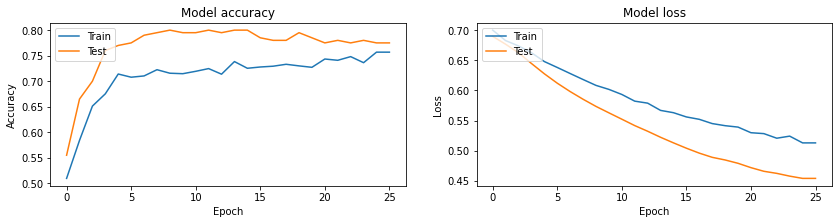

In [26]:
from matplotlib import pyplot as plt
# Plot training & validation accuracy values
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights("best_model.h5")
model.evaluate(x = test_dba)

In [ ]:
%tensorboard --logdir logs
#Use '!kill (pid)' to kill it

### 7. Prediction
#### 7.1 Preparing Lansat 8 imagery

In [28]:
l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")\
               .filterBounds(Marmaris)\
               .filterDate('2019-01-01', '2019-12-31')\
               .filter(ee.Filter.lt('CLOUD_COVER', 20))\
               .map(maskS2clouds)\
               .median()\
               .multiply(0.0001)\
               .clip(Marmaris)

l8_ndvi = l8.normalizedDifference(NDVI_bands).rename(['NDVI'])
l8_rgb = l8.select(RGB_bands).rename(['R','G','B']) 
l8 = l8_rgb.addBands(l8_ndvi)

#### 7.2 Exporting the result to Storage Bucket
For export the results to the Google Cloud Storage, it's preferred defines the following `formatOptions` parameters to save memory:

- **patchDimensions**:	Patch dimensions tiled over the export area, covering every pixel in the bounding box exactly once (except when the patch dimensions do not evenly divide the bounding box in which case the lower and right sides are trimmed).

- **compressed**: If true, compresses the .tfrecord files with gzip and appends the ".gz" suffix	

See all the paramerters [here](https://developers.google.com/earth-engine/exporting#configuration-parameters).

In [29]:
imageFilePrefix = 'MarmarisAgronomi'

# Specify patch and file dimensions.
imageExportFormatOptions = {
  'patchDimensions': [64, 64],  
  'maxFileSize': 100000000,    
  'compressed': True
}

# Setup the task.
imageTask = ee.batch.Export.image.toCloudStorage(
  image=l8,
  description='Image Export',
  fileNamePrefix=imageFilePrefix,
  bucket=outputBucket,
  scale=30,
  fileFormat='TFRecord',
  region=Marmaris.getInfo()['coordinates'],
  formatOptions=imageExportFormatOptions,
)

imageTask.start()

In [30]:
import time 
while imageTask.active():
  print('Polling for task (id: {}).'.format(imageTask.id))
  time.sleep(5)

Polling for task (id: MOLP6HGSWPHS5JLSDHWQGY5B).
Polling for task (id: MOLP6HGSWPHS5JLSDHWQGY5B).
Polling for task (id: MOLP6HGSWPHS5JLSDHWQGY5B).


#### 7.3 Classifying the image
To classify the image that is exported from GEE to Storage Bucket using Tensorflow,  a JSON sidecar file called "the mixer" describes the format and geo-referencing of the image.

There will be the image files and the mixer file, getting some info out of the mixer that will be useful during model inference.

In [31]:
filesList = !gsutil ls 'gs://'{outputBucket}
exportFilesList = [s for s in filesList if imageFilePrefix in s]

# Get the list of image files and the JSON mixer file.
imageFilesList = []
jsonFile = None
for f in exportFilesList:
  if f.endswith('.tfrecord.gz'):
    imageFilesList.append(f)
  elif f.endswith('.json'):
    jsonFile = f

# Make sure the files are in the right order.
print(jsonFile)

gs://marmaris_agronomy/MarmarisAgronomi.json


#### 7.4 Load the contents of the mixer file to a JSON object
The mixer contains metadata and geo-referencing information for the exported patches, each of which is in a different file.

In [32]:
import json
from pprint import pprint 

jsonText = !gsutil cat {jsonFile}
# Get a single string w/ newlines from the IPython.utils.text.SList
mixer = json.loads(jsonText.nlstr)
pprint(mixer)

{'patchDimensions': [64, 64],
 'patchesPerRow': 2,
 'projection': {'affine': {'doubleMatrix': [0.00026949458523585647,
                                            0.0,
                                            28.31579607073144,
                                            0.0,
                                            -0.00026949458523585647,
                                            37.065207274998755]},
                'crs': 'EPSG:4326'},
 'totalPatches': 2}


#### 7.5 Feeding trained model to make predictions
The next function, mainly, is about the pixels are written into records as patches, we need to read the patches in as one big tensor (one patch for each band), then flatten them into lots of little tensors. 

Once the predict_input_fn is defined, that can handle the shape of the image data, all you need to do is feed it directly to the trained model to make predictions.

In [33]:
def predict_input_fn(fileNames,patch,bands):

  # You have to know the following from your export.
  PATCH_WIDTH, PATCH_HEIGHT = patch
  PATCH_DIMENSIONS_FLAT = [PATCH_WIDTH * PATCH_HEIGHT, 1]

  # Note that the tensors are in the shape of a patch, one patch for each band.
  imageColumns = [
    tf.io.FixedLenFeature(shape=PATCH_DIMENSIONS_FLAT, dtype=tf.float32) 
      for k in bands
  ]

  featuresDict = dict(zip(bands, imageColumns))
  dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')
  
  # Make a parsing function
  def parse_image(example_proto):
    parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
    return parsed_features

  dataset = dataset.map(parse_image, num_parallel_calls=4)
  
  # Break our long tensors into many littler ones
  #https://stackoverflow.com/questions/50530806/using-flat-map-in-tensorflows-dataset-api
  dataset = dataset.flat_map(lambda features: tf.data.Dataset.from_tensor_slices(features))

  # Read in batches corresponding to patch size.
  dataset = dataset.batch(PATCH_WIDTH * PATCH_HEIGHT)

  return dataset

In [ ]:
predict_db = predict_input_fn(fileNames=imageFilesList,patch=[64,64],bands=['R', 'G', 'B', 'NDVI'])
predictions = model.predict(predict_db)

#### 7.6 Dumping every patch-worth of predictions
Every patch-worth of predictions, it'll be dumped an example into the output file with a single feature that holds our predictions. Since our predictions are already in the order of the exported data, the patches we create here will also be in the right order.

There is a `np.array` of probabilities in "predictions" to write them back into a file. It will write directly from TensorFlow to a file in the output Cloud Storage bucket.

Iterate over the list and write the probabilities in patches. Specifically, we need to write the pixels into the file as patches in the same order they came out. The records are written as serialized tf.train.Example protos. This might take a while.

In [35]:
PATCH_WIDTH , PATCH_HEIGHT = [64,64]
outputImageFile = 'gs://' + outputBucket + '/MarmarisAgronomi.TFRecord'
writer = tf.io.TFRecordWriter(outputImageFile)

patch = []
curPatch = 1
for  prediction in predictions:
  patch.append(prediction)
  
  if (len(patch) == PATCH_WIDTH * PATCH_HEIGHT):
    print('Done with patch ' + str(curPatch) + '...')    
    # Create an example
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'crop_prob': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=patch))
        }
      )
    )
    
    writer.write(example.SerializeToString())
    patch = []
    curPatch += 1 

writer.close()

Done with patch 1...
Done with patch 2...


#### 7.7 Uploading the classifications to an Earth Engine asset

At this stage, there should be a predictions TFRecord file sitting in the output Cloud Storage bucket. Use the gsutil command to verify that the predictions image (and associated mixer JSON) exist and have non-zero size.

In [ ]:
!gsutil ls -l {outputImageFile}

Upload the image to Earth Engine directly from the Cloud Storage bucket with the [earthengine command](https://developers.google.com/earth-engine/command_line#upload). Provide both the image TFRecord file and the JSON file as arguments to earthengine upload.

In [ ]:
USER_NAME = 'patikan' # replace with your GEE username
outputAssetID = 'users/' + USER_NAME + '/MarmarisAgronomi'
print('Writing to ' + outputAssetID)

Starting the upload - this step might take a while.

In [ ]:
print('outputAssetID: ' + outputAssetID + 'outputImageFile: ' +  outputImageFile + 'jsonFile: ' + jsonFile)
!earthengine upload image --asset_id={outputAssetID} {outputImageFile} {jsonFile}

#### 7.8 Displaying Prediction
Display the results for the selected area by using Folium!

In [39]:
ProbsImage = ee.Image(outputAssetID)
predictionsImage = ee.Image(outputAssetID).gte(0.500)
dicc = {'Marmaris':l8Mapid,'CropProbability':ProbsImage.getMapId(),
        'Crop':predictionsImage.getMapId()}

center = Marmaris.centroid().getInfo()['coordinates']
center.reverse()

Mapdisplay(center=center,dicc=dicc,zoom_start=12)